# MNIST Classification Hybrid Model

Classical layers using keras dense and quantum layers using Pennylane

In [ ]:
"""
Sophie Choe 9/27/2019

I did only 100 epochs with 600 training data set. From the loss and accuracy graphs, it seems the model 
needs more epochs for actual convergence
"""

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# ===================================================================================
#                                Data Preparation
# ===================================================================================

mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the image data
X_train, X_test = X_train / 255.0, X_test / 255.0

def one_hot(labels):  
    
    
    depth = 16                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
X_train, X_test, y_train, y_test = X_train[:600], X_test[:100], y_train[:600], y_test[:100]

In [3]:
# ===================================================================================
#                                   Classical Layers
# ===================================================================================

# Define classical layers using Keras Sequential

keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(32, activation ="elu"),
                                 layers.Dense(14, activation ="elu") 
                                ])

In [4]:
# ===================================================================================
#                                Quantum Iterative Layer
# ===================================================================================

# quantum state preparation by using the output of the classical network as parameters

def init_layer(x):
    qml.Squeezing(x[3], x[4], wires=0)
    qml.Squeezing(x[9], x[10], wires=1)
    qml.Beamsplitter(x[5], x[6], wires=[0,1])
    qml.Rotation(x[7], wires=0)
    qml.Rotation(x[8], wires=1)
    qml.Displacement(x[1], x[2], wires=0)
    qml.Displacement(x[11], x[12], wires=1)
    qml.Kerr(x[0], wires=0)
    qml.Kerr(x[13], wires=1)

# quantum layer for iteration

def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)

In [5]:
# ===================================================================================
#                                Quantum Circuit
# ===================================================================================

# initialize parameters for the quantum layers: number of layers x number of parameters needed for all the gates

def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 2 + 1 + 1  # Number of interferometer parameters: beamsplitter + 2 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

num_modes = 2
num_basis = 4

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    init_layer(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)
    
    #return [qml.expval(qml.X(0)), qml.expval(qml.X(1))]
    return qml.probs(wires=[0, 1])

In [6]:
# ===================================================================================
#                                  Hybrid Model
# ===================================================================================

"""
Add the quantum layer to the classical to create a hybrid model
    1. initialize weights for quantum layers
    2. create a dictionary of weight shape to pass as one of the variables to covert to keras layer
    3. convert the quantum layer to a Keras layer
    4. add to the classical sequential model
"""

num_layers = 4

weigths = init_weights(num_layers, num_modes)
shape_tup = weigths.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)
model.add(qlayer)

In [7]:
# ===================================================================================
#                                   Training
# ===================================================================================

opt = keras.optimizers.SGD(learning_rate=0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 100,
                   batch_size = 50,
                   shuffle = True)

Epoch 1/100
12/12 [==============================] - 371s 30s/step - loss: 2.7393 - accuracy: 0.1169
Epoch 2/100
12/12 [==============================] - 324s 27s/step - loss: 2.2381 - accuracy: 0.1887
Epoch 3/100
12/12 [==============================] - 317s 26s/step - loss: 1.9957 - accuracy: 0.3360
Epoch 4/100
12/12 [==============================] - 287s 23s/step - loss: 1.8459 - accuracy: 0.4233
Epoch 5/100
12/12 [==============================] - 255s 21s/step - loss: 1.6486 - accuracy: 0.5533
Epoch 6/100
12/12 [==============================] - 258s 22s/step - loss: 1.6674 - accuracy: 0.5406
Epoch 7/100
12/12 [==============================] - 326s 27s/step - loss: 1.6282 - accuracy: 0.5321
Epoch 8/100
12/12 [==============================] - 318s 27s/step - loss: 1.4503 - accuracy: 0.6006
Epoch 9/100
12/12 [==============================] - 329s 27s/step - loss: 1.5099 - accuracy: 0.5750
Epoch 10/100
12/12 [==============================] - 322s 27s/step - loss: 1.5026 - accura

12/12 [==============================] - 379s 32s/step - loss: 0.5642 - accuracy: 0.9610
Epoch 82/100
12/12 [==============================] - 360s 29s/step - loss: 0.5771 - accuracy: 0.9610
Epoch 83/100
12/12 [==============================] - 374s 31s/step - loss: 0.5811 - accuracy: 0.9322
Epoch 84/100
12/12 [==============================] - 375s 31s/step - loss: 0.5574 - accuracy: 0.9580
Epoch 85/100
12/12 [==============================] - 364s 30s/step - loss: 0.5315 - accuracy: 0.9666
Epoch 86/100
12/12 [==============================] - 373s 31s/step - loss: 0.5502 - accuracy: 0.9618
Epoch 87/100
12/12 [==============================] - 370s 31s/step - loss: 0.5694 - accuracy: 0.9567
Epoch 88/100
12/12 [==============================] - 377s 31s/step - loss: 0.5402 - accuracy: 0.9746
Epoch 89/100
12/12 [==============================] - 392s 33s/step - loss: 0.4965 - accuracy: 0.9649
Epoch 90/100
12/12 [==============================] - 390s 32s/step - loss: 0.5463 - accuracy: 

In [17]:
# ===================================================================================
#                                    Evalutation
# ===================================================================================

results = model.evaluate(X_test, y_test, batch_size=50)
print("test loss, test acc:", results)

2/2 [==============================] - 2s 835ms/step - loss: 0.0502 - accuracy: 0.7200
test loss, test acc: [0.05017095431685448, 0.7200000286102295]


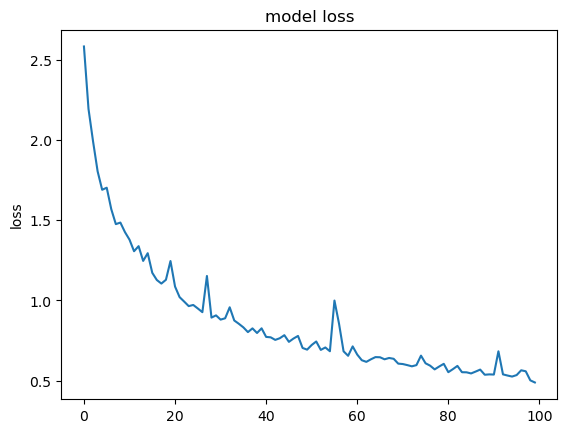

In [12]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'])
plt.ylabel('loss')
plt.show()

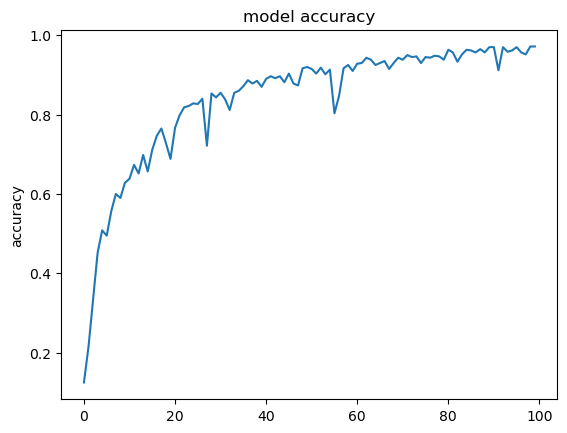

In [13]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'])
plt.ylabel('accuracy')
plt.show()